# 2024 Car Price Analysis

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings
import scikit_posthocs as sp
from sklearn.model_selection import cross_val_score


## Read data

In [2]:
df = pd.read_csv("carlist.csv",index_col = 0)
df.head()

### Data Management

In [3]:
df['year'] = df.title.str.split(" ",expand = True)[0].astype(int)
df['brand'] = df.title.str.split(" ",expand = True)[1]
df['state'] =df.location.str.split(', ',expand = True)[1]
df['price'] = [df.price.iloc[i].split('\n')[0] for i in range(len(df))] ## loop through each price to take the first element of that string price
df = df.drop(df[df['price'] == 'Not Priced'].index) ## drop rows not compatible with other rows
df['price'] = df['price'].replace('[\$,]','',regex=True).astype(float) ## convert money str to float
df['mileage'] = df['mileage'].str.split(" ",expand = True)[0].replace(',','',regex=True).astype(int) ## convert mileage to int
df.head(1)

,title,deal_rating,mileage,price,stock_type,location,year,brand,state
0,2021 Toyota RAV4 Prime SE,Good Deal,53717,36998.0,Used,"Reno, NV",2021,Toyota,NV


## EDA for global car stats

* does brand influence price
* does mileage influence price
* is their a difference between stock_type, deal_rating 
* is their a difference between mileage amd top 5 brands
* analyze top 5 brands to see any difference on price
* does year affect price


* Does brand influence price?

In [4]:
car_brand_stat = df.groupby('brand').price.agg(['count','mean','min','max']).sort_values(by='count',ascending=False )## finding the volumne of cars on the market

In [5]:
top18_brand = pd.Series(car_brand_stat.index[:18]) ## column filter top 18 brands by count
analysis1 = df.loc[(df.brand.isin(top18_brand))]
analysis1.head()

### Normality

Shapiro's wilks test Statistics=0.996, p=0.000
Sample is non-normal


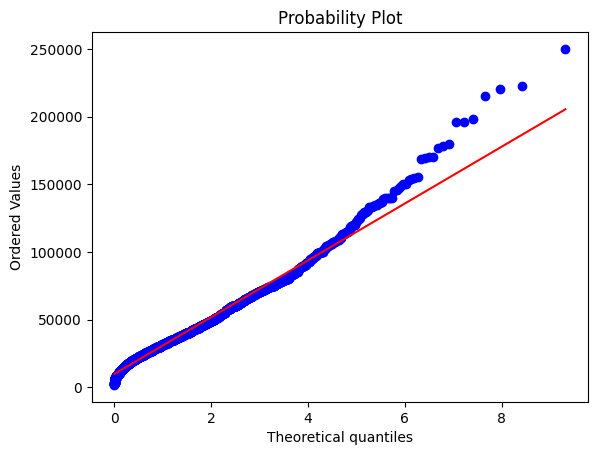

In [24]:
stat, p = stats.shapiro(np.log(analysis1['price']))
print("Shapiro's wilks test Statistics=%.3f, p=%.3f" % (stat, p))
# Interpret the result
alpha = 0.05
if p > alpha:
    print('Sample is normal')
else:
    print('Sample is non-normal')
    measurements = np.array(analysis1['price'])
stats.probplot(measurements, dist="expon", plot=plt)
plt.show()

price is not normally distributed looking at the q-q plot

#### Constant variance among the brand on price?

In [33]:
k1 = analysis1.loc[analysis1['brand'] == top18_brand[0]].price
k2 = analysis1.loc[analysis1['brand'] == top18_brand[1]].price
k3 = analysis1.loc[analysis1['brand'] == top18_brand[2]].price
k4 = analysis1.loc[analysis1['brand'] == top18_brand[3]].price
k5 = analysis1.loc[analysis1['brand'] == top18_brand[4]].price


result = stats.levene(k1,k2,k3,k4,k5, center='median')
print("Brown-forsythe:")
print("Test statistic:", result.statistic)
print("p-value:", result.pvalue)
if result.pvalue > .05:
    print("The variances not equal")
else:
    print("At least one variance differs")

Brown-forsythe:
Test statistic: 79.03516010890652
p-value: 3.323306105292436e-64
At least one variance differs


### Distribution Among prices by Brands

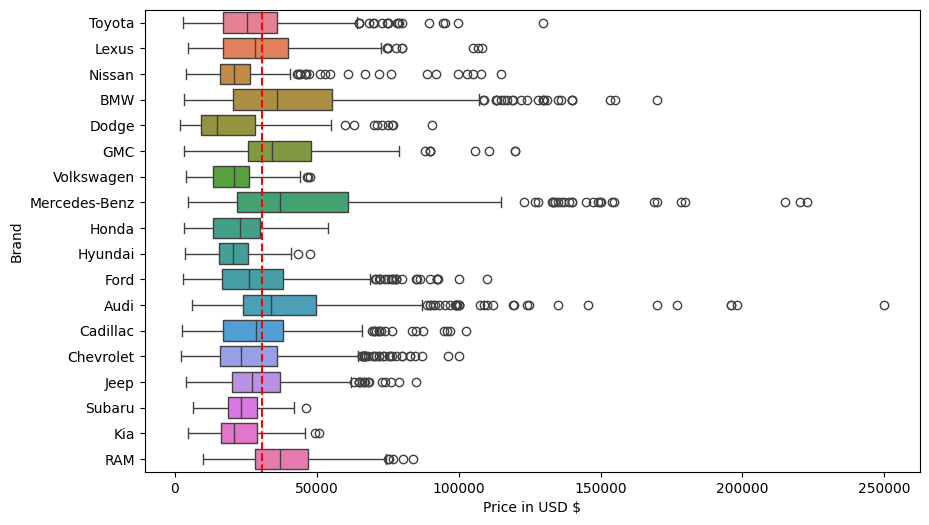

In [63]:
plt.figure(figsize=(10,6))
fig2 = sns.boxplot(y='brand', x='price',hue = 'brand', data= analysis1)
fig2.axvline(np.mean(analysis1['price']), color='red', linestyle='--')
plt.xlabel('Price in USD $')
plt.ylabel('Brand')
plt.show()

In [64]:
# boxplot of car price by brand if varying years
def boxplot_yr(yr):
    plt.figure(figsize=(10,8))
    fig2 = sns.boxplot(y='brand', x='price',hue = 'brand', data= analysis1.loc[analysis1['year'] == yr])
    fig2.axvline(np.mean(analysis1.loc[analysis1['year']== yr].price), color='red', linestyle='--')
    plt.xlabel('Price in USD $')
    return
# boxplot_yr(2018)

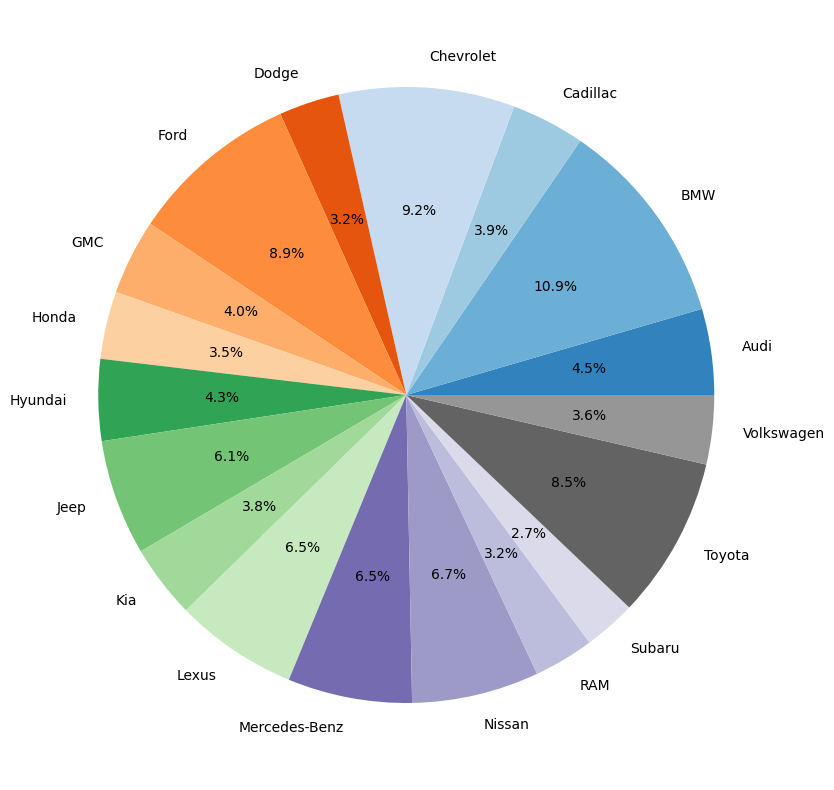

In [69]:
# pie chart of the brands
plt.figure(figsize = (10,10))
# Define labels and sizes for the slices
labels = analysis1.groupby(analysis1['brand']).size().index
sizes = analysis1.groupby(analysis1['brand']).size()

# setting colors
colors = sns.color_palette("tab20c")

# Create a pie chart

plt.pie(sizes, labels =labels, colors = colors, autopct='%1.1f%%')

# Display the chart
plt.show()


## EDA for toyota

In [13]:
toyota_df = analysis1.loc[analysis1.brand =='Toyota']
toyota_df['model'] = toyota_df.title.str.split(" ",expand = True)[2]

array(['RAV4', 'Sienna', 'Matrix', 'Supra', 'Tundra', 'Land', 'Yaris',
       'Camry', '4Runner', 'Corolla', 'GR86', 'FJ', 'Sequoia', 'Prius',
       'Highlander', 'GR', 'Tacoma', 'Grand', 'Crown', 'Avalon', 'Venza',
       'ECHO', 'Mirai', 'MR2', '86', 'C-HR', 'Pickup', 'Celica', 'bZ4X'],
      dtype=object)